In [86]:
import pandas as pd
import numpy as np
import os
import sys
from  networkx import bipartite
sys.path.append('./../..')
sys.path.append('./..')
import glob
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed
from pandarallel import pandarallel

pandarallel.initialize()
import re
import yaml
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

id_col = 'PanjivaRecordID'
import networkx as nx
import operator
import collections
import argparse
from networkx.algorithms import community
CONFIG = None
DIR_LOC = None
CONFIG = None
CONFIG_FILE = 'config.yaml'
save_dir = None
id_col = 'PanjivaRecordID'
use_cols = None
freq_bound = None
attribute_columns = None
DIR = None
CUT_OFF = None
ANOM_PERC_LB  = 1.00
ANOM_PERC_UB = 5.00
MAX_CLUSTERS = 10

def set_up_config(_DIR=None):
    global DIR
    global CONFIG
    global CONFIG_FILE
    global use_cols
    global num_neg_samples
    global DATA_SOURCE
    global DIR_LOC
    global save_dir
    global id_col
    global attribute_columns

    DATA_SOURCE = './../generated_data_v1/'
    with open(CONFIG_FILE) as f:
        CONFIG = yaml.safe_load(f)

    if _DIR is not None:
        DIR = _DIR
        CONFIG['DIR'] = _DIR
    else:
        DIR = CONFIG['DIR']

    DIR_LOC = re.sub('[0-9]', '', DIR)
    DATA_SOURCE = os.path.join(DATA_SOURCE, DIR)
    save_dir = 'stage_2'
    save_dir = os.path.join(
        DATA_SOURCE,
        save_dir
    )

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    use_cols = CONFIG[DIR]['use_cols']
    _cols = list(use_cols)
    _cols.remove(id_col)
    attribute_columns = list(sorted(_cols))
    return

# DIR = 'us_import1'
# set_up_config()



def generate_edge_clusters(
    G, 
    comm, 
    max_pairs = 2,
    grow_size = 3,
    grow_steps= 2,
    min_size = 5
):
    import operator 
    global CUT_OFF
    
    DEGREE_LB = 3
    DEGREE_UB = CUT_OFF+2
    
    DEGREE_LB = max(grow_size, DEGREE_LB)
#     sg_obj = G.subgraph(comm)
    sg_obj = nx.Graph(G)
    print(sg_obj.number_of_edges(),sg_obj.number_of_nodes())
    edgeWt_dict = {}
    for e in sg_obj.edges():
        edgeWt_dict[e] = sg_obj.get_edge_data(e[0],e[1])['weight']

    wt_lb = 2
    wt_ub = 15
    candidate_edges = {}
    for edge,wt in edgeWt_dict.items():
        if wt < wt_lb or wt > wt_ub: continue 
        if  sg_obj.degree(e[0]) < DEGREE_LB and sg_obj.degree(e[1]) < DEGREE_LB : continue
        if  sg_obj.degree(e[0]) > DEGREE_UB and sg_obj.degree(e[1]) > DEGREE_UB :continue
        candidate_edges[edge] = wt * ((sg_obj.degree(e[0])+sg_obj.degree(e[1]))/2)/ DEGREE_UB
        
    print(' >', len(candidate_edges))
    candidate_edges  = sorted(
        candidate_edges.items(),
        key = operator.itemgetter(1), 
        reverse=True
    )
    marked_edges = []
    count = 0
    for edge_item in candidate_edges:
        flag = True
        seed1 = edge_item[0][0]
        seed2 = edge_item[0][1]   
        target_nodes = [seed1,seed2]
        expansion_dict = { 1: [seed1,seed2] }
        for g in range(2, grow_steps + 1):
            expansion_dict[g] = []
            for t in expansion_dict[g-1]:
                t_nbrs = []
                for N in sg_obj.neighbors(t):
                    if sg_obj.degree(N)< DEGREE_LB or sg_obj.degree(N)>DEGREE_UB or N == t: 
                        continue
                    wt = sg_obj.get_edge_data(t,N)['weight']
                    if wt <= wt_lb or wt > wt_ub: continue
                    t_nbrs.append(N)
                try: 
                    t_nbrs = np.random.choice(t_nbrs,grow_size,replace=True)
                    target_nodes.extend(t_nbrs)
                except: 
                    flag = False
                    continue
                expansion_dict[g].extend(set(t_nbrs))
        new_subgraph = sg_obj.subgraph(target_nodes)
        
        if new_subgraph.number_of_edges() >= min_size and flag : 
            print( 'Number of edges in new cluster subgraph', new_subgraph.number_of_edges())
            count +=1
            marked_edges.extend(new_subgraph.edges())
            
            print(marked_edges)
            marked_edges = list(marked_edges)
        if count >= max_pairs: 
            break
    return marked_edges  


# ----------------------------------------- #
# Main process
# ----------------------------------------- #
def main_process():
    global DIR, DATA_SOURCE, ANOM_PERC_LB, ANOM_PERC_UB
    
    company_cols = ['ConsigneePanjivaID', 'ShipperPanjivaID']
    company_col_abbr = {'C': 'ConsigneePanjivaID', 'S': 'ShipperPanjivaID'}
    # -----------------------------------------------------------

    df = pd.read_csv(
        os.path.join(DATA_SOURCE, 'train_data.csv'),
        low_memory=False,
        index_col=None
    )
    attributes = [ _ for _ in list(df.columns) if _ not in id_col]
    df = df.drop_duplicates(subset = attributes)
    df_subset = df[company_cols].groupby(
        company_cols).size().reset_index(
        name='count').sort_values(by='count', ascending=False)

    df_subset['ConsigneePanjivaID'] = df_subset['ConsigneePanjivaID'].apply(
        lambda x: 'C' + str(x)
    )

    df_subset['ShipperPanjivaID'] = df_subset['ShipperPanjivaID'].apply(
        lambda x: 'S' + str(x)
    )
    df_test = pd.read_csv(
        os.path.join(DATA_SOURCE, 'test_data.csv'),
        low_memory=False,
        index_col=None
    )
    df_test = df_test.drop_duplicates(subset=attribute_columns)



    # --------------------
    # Create a bipartite graph
    # --------------------
    B = nx.Graph()
    B.add_nodes_from(set(df_subset['ConsigneePanjivaID'].values), bipartite=0)
    B.add_nodes_from(set(df_subset['ShipperPanjivaID'].values), bipartite=1)
    edges = []
    for i, j, k in zip(df_subset['ConsigneePanjivaID'].values,
                       df_subset['ShipperPanjivaID'].values,
                       df_subset['count'].values):
        edges.append((i, j, {'weight': k}))

    B.add_edges_from(edges)
    print(' IS the bipartite graph of Comapnies connected ? ', nx.is_connected(B))

    #  ---------------------------
    # Remove nodes that are in 90th percentile of degree or more
    # That is remove companies that are higly connected - since those are visible and deemed not suspicous/malacious
    # ----------------------------
    degree_sequence = sorted([d for n, d in B.degree()], reverse=True)
    CUT_OFF = int(np.percentile(degree_sequence, 90))
    print(' cut off degree ', CUT_OFF)

    B1 = nx.Graph(B)
    
    # ====================
    
    FOUND = False
    subgraph = None

    while FOUND == False:

        edges = generate_edge_clusters(
            B, 
            max_pairs = 30,  
            grow_size= 3, 
            grow_steps = 5,
            min_size = 8
        )
        ref_df = df_test.copy()
        record_count = 0
        for pair in edges:
            record_count +=len(ref_df.loc[
                (ref_df['ConsigneePanjivaID']== int(pair[0][1:])) &
                (ref_df['ShipperPanjivaID']==int(pair[1][1:]))
            ])
        percentage = record_count/len(ref_df) * 100
        print(' [  ======>  ]', percentage)
        if percentage > ANOM_PERC_LB and percentage <= ANOM_PERC_UB:
            FOUND = True
        nodes = []
        for e in edges: nodes.extend(e)
        subgraph = B.subgraph(nodes)


        print('# of nodes & edges in the extracted forest/subgraph :', subgraph.number_of_nodes(), subgraph.number_of_edges() )
        num_components = 0
        for i in nx.connected_components(subgraph):
            print(len(i))
            num_components +=1
        if num_components > MAX_CLUSTERS:
            FOUND=False

        try:
            import matplotlib.pyplot as plt
            import networkx as nx
            pos = nx.spring_layout(subgraph)
            nx.draw(subgraph, pos, node_size=100, cmap=plt.cm.Blues)
            plt.show()
        except:
            pass



    target_edges = list(subgraph.edges())
    target_edges = [ sorted(_) for _ in target_edges]

    result_edge_pairs = {}
    for d in company_col_abbr.values():
        result_edge_pairs[d] = []

    for e in target_edges:
        e1 = int(e[0][1:])
        d1 = company_col_abbr[e[0][0]]
        result_edge_pairs[d1].append(e1)
        e2 = int(e[1][1:])
        d2 = company_col_abbr[e[1][0]]
        result_edge_pairs[d2].append(e2)

    result_df = pd.DataFrame.from_dict(result_edge_pairs)

    print('Result dataframe, with edge list', len(result_df))

    # Save the results
    f_path = os.path.join(save_dir, 'seed_edges.csv')
    result_df.to_csv(f_path, index=None)
    
    
    return result_df


parser = argparse.ArgumentParser()
parser.add_argument(
    '--DIR', choices=['us_import1', 'us_import2', 'us_import3'],
    default='us_import1'
)

args = parser.parse_args()
DIR = args.DIR
set_up_config(
    DIR
)
main_process()



21
22
26
18
11
24
7


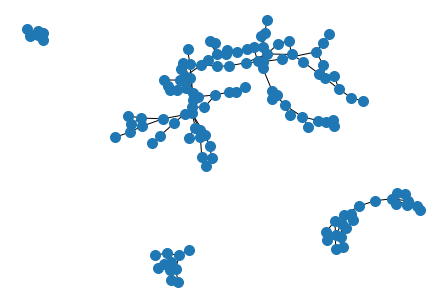

In [66]:


# nx.draw(subgraph,size=10)

In [ ]:
print(' IS the bipartite graph of Comapnies connected ? ', nx.is_connected(subgraph))